In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer


c:\Users\Home\efficiently_serving_LLMs\llms\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [3]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [4]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")

In [5]:
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [6]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits

In [7]:
logits[0, 2, :].shape

torch.Size([50257])

El modelo genera las probabilidades de generar el próximo token para cada token de entrada
pero sólo nos interesa el último

In [8]:
print(logits.shape)

torch.Size([1, 7, 50257])


In [9]:
last_logits = logits[0,-1, :]
# Greedy
next_token_id = last_logits.argmax()


In [10]:
print(next_token_id)

tensor(13990)


In [11]:
tokenizer.decode(next_token_id)

' fence'

In [12]:
top_k = torch.topk(last_logits, k = 10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]

In [13]:
tokens

[' fence',
 ' edge',
 ' railing',
 ' wall',
 ' table',
 ' tree',
 ' top',
 ' counter',
 ' ground',
 ' side']

In [14]:
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [15]:
next_inputs = {
    "input_ids" : torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1,1))],
        dim=1
    ),
    "attention_mask" : torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim = 1
    )
}

In [16]:
print(next_inputs["input_ids"],
      next_inputs["input_ids"].shape)
print(next_inputs["attention_mask"],
      next_inputs["attention_mask"].shape)


tensor([[  464,  2068,  7586, 21831, 11687,   625,   262, 13990]]) torch.Size([1, 8])
tensor([[1, 1, 1, 1, 1, 1, 1, 1]]) torch.Size([1, 8])


In [17]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    last_logits = logits[0,-1, :]
    next_token_id = last_logits.argmax()
    return next_token_id

In [18]:
generated_tokens = []
next_inputs = inputs
duration_s = []

In [19]:
for _ in range(10):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    duration_s += [time.time() - t0]

    next_inputs = {
        "input_ids" : torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1,1))],
            dim = 1
        ),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim = 1
        )
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)


In [20]:
print(f"{sum(duration_s)} s")

2.968815326690674 s


In [21]:
print(generated_tokens)

[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


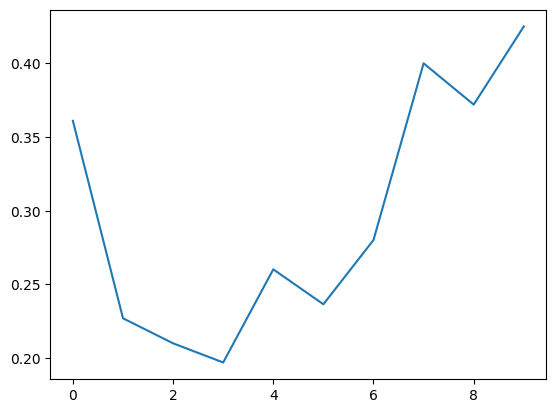

In [22]:
plt.plot(duration_s)
plt.show()

In [23]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    last_logits = logits[0,-1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

In [24]:
generated_tokens = []
next_inputs = inputs
durations_cached_s = []

In [25]:
for _ in range(10):
    t0 = time.time()
    next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]

    next_inputs = {
        "input_ids" : next_token_id.reshape((1,1)),
        "attention_mask" : torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim = 1),
        "past_key_values" : past_key_values,
    }
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)


In [26]:
print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

0.874990701675415 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


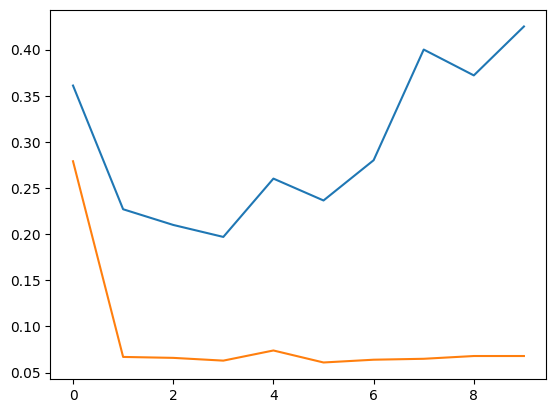

In [28]:
plt.plot(duration_s)
plt.plot(durations_cached_s)
plt.show()